In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from torch import nn
import shap
import polars as pl

Comments for file omitted as this is intended to be a sample view of how models were trained on differing input data (in this case with limited temporal features)

In [ ]:
filepath = "./9417_imputed_data"
device = "cuda" if torch.cuda.is_available() else "cpu"
testsplit = 7110

device

'cuda'

In [ ]:
df_lag_base = pl.read_ipc(filepath + "/denormalised, with lags.parquet").to_pandas()
df_lag_01 = pl.read_ipc(filepath + "/min-max scaled, with lags.parquet").to_pandas()
df_lag_z = pl.read_ipc(filepath + "/Z-score normalised, with lags.parquet").to_pandas()

In [ ]:
# extract base datafiles without temporal data
cols = [
   'DateTime', 'Date', 'Time', 'linear_dt', 'sin_time_of_year',
   'cos_time_of_year', 'is_mon', 'is_tue', 'is_wed', 'is_thu', 'is_fri',
   'is_sat', 'is_sun', 'is_weekday', 'sin_time_of_week',
   'cos_time_of_week', 'sin_hour_of_day', 'cos_hour_of_day', 'CO(GT)',
   'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)',
   'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH','AH'
]
df_nolag_base = pl.read_ipc(filepath + "/denormalised, with lags.parquet").select(cols).to_pandas()
df_nolag_01 = pl.read_ipc(filepath + "/min-max scaled, with lags.parquet").select(cols).to_pandas()
df_nolag_z = pl.read_ipc(filepath + "/Z-score normalised, with lags.parquet").select(cols).to_pandas()

In [ ]:
# extracted significant rolling averages based on empirical analysis of shapley values when training with all lagging values
# includes all rolling average features within top 20 for each class/horizon pair
t1class0 = ["PT08.S4(NO2)", "CO(GT)", "NOx(GT)", "NO2(GT)", "PT08.S2(NMHC)", "C6H6(GT)", "PT08.S3(NOx)", "PT08.S1(CO)", "NMHC(GT)", "PT08.S5(O3)", "T_wdw[-(1week):(0hour)]", "NO2(GT)_wdw[-(3hour):-(2hour)]", "PT08.S4(NO2)_wdw[-(2week):-(2week-1hour)]", "T_wdw[-(3week):-(3week-1hour)]", "PT08.S4(NO2)_wdw[-(1week):(0hour)]", "NOx(GT)_wdw[-(3week):-(1week-1hour):1week]", "PT08.S5(O3)_wdw[-(3day):-(3day-1hour)]", "AH_wdw[-(2week):-(2week-1hour)]", "PT08.S5(O3)_wdw[-(6day):-(6day-1hour)]", "PT08.S4(NO2)_wdw[-(1week):-(1week-1hour)]"]
t1class1 = ["PT08.S4(NO2)", "NO2(GT)", "CO(GT)", "NOx(GT)", "C6H6(GT)", "PT08.S3(NOx)", "PT08.S2(NMHC)", "PT08.S1(CO)", "T_wdw[-(1week):-(1week-1hour)]", "PT08.S4(NO2)_wdw[-(3day):-(1day-1hour):1day]", "NMHC(GT)", "NO2(GT)_wdw[-(2week):-(2week-1hour)]", "AH_wdw[-(2day):-(1day-1hour):1day]", "T", "T_wdw[-(2day):-(2day-1hour)]", "PT08.S5(O3)", "T_wdw[-(3day):-(3day-1hour)]", "NO2(GT)_wdw[-(1hour):(0hour)]", "NO2(GT)_wdw[-(1week):(0hour)]", "AH_wdw[-(2week):-(1week-1hour):1week]"]
t1class2 = ["PT08.S4(NO2)", "CO(GT)", "NOx(GT)", "C6H6(GT)", "PT08.S3(NOx)", "NO2(GT)", "PT08.S2(NMHC)", "PT08.S1(CO)", "NMHC(GT)", "PT08.S5(O3)", "AH_wdw[-(2week):-(2week-1hour)]", "T_wdw[-(1week):(0hour)]", "PT08.S4(NO2)_wdw[-(2week):-(2week-1hour)]", "PT08.S4(NO2)_wdw[-(1week):(0hour)]", "NO2(GT)_wdw[-(3hour):-(2hour)]", "T_wdw[-(5day):-(5day-1hour)]", "T_wdw[-(3week):-(3week-1hour)]", "PT08.S4(NO2)_wdw[-(3week):-(3week-1hour)]", "NOx(GT)_wdw[-(3week):-(1week-1hour):1week]", "NOx(GT)_wdw[-(3week):-(3week-1hour)]"]
t6class0 = ["T_wdw[-(3hour):-(2hour)]", "T", "T_wdw[-(1week):(0hour)]", "T_wdw[-(2week):-(2week-1hour)]", "T_wdw[-(3week):-(3week-1hour)]", "RH", "RH_wdw[-(3hour):-(2hour)]", "PT08.S4(NO2)", "NO2(GT)_wdw[-(3hour):-(2hour)]", "NO2(GT)_wdw[-(4day):-(4day-1hour)]", "T_wdw[-(5day):-(1day-1hour):1day]", "T_wdw[-(3hour):(0hour)]", "NO2(GT)_wdw[-(1week):(0hour)]", "T_wdw[-(5day):-(5day-1hour)]", "NO2(GT)", "NOx(GT)", "T_wdw[-(1hour):(0hour)]", "NO2(GT)_wdw[-(3hour):(0hour)]", "PT08.S4(NO2)_wdw[-(2week):-(2week-1hour)]", "NO2(GT)_wdw[-(2week):-(2week-1hour)]"]
t6class1 = ["T_wdw[-(3week):-(3week-1hour)]", "T", "NO2(GT)_wdw[-(3hour):-(2hour)]", "T_wdw[-(3hour):-(2hour)]", "NO2(GT)_wdw[-(2hour):-(1hour)]", "T_wdw[-(1week):(0hour)]", "RH", "T_wdw[-(3week):-(1week-1hour):1week]", "NO2(GT)", "PT08.S4(NO2)", "T_wdw[-(1hour):(0hour)]", "T_wdw[-(5day):-(1day-1hour):1day]", "T_wdw[-(2week):-(2week-1hour)]", "RH_wdw[-(3week):-(3week-1hour)]", "PT08.S2(NMHC)_wdw[-(3hour):-(2hour)]", "T_wdw[-(3hour):(0hour)]", "PT08.S4(NO2)_wdw[-(1hour):(0hour)]", "T_wdw[-(1week):-(1week-1hour)]", "NO2(GT)_wdw[-(3hour):(0hour)]", "T_wdw[-(1week):-(1day-1hour):1day]"]
t6class2 = ["T_wdw[-(3hour):-(2hour)]", "T_wdw[-(1week):(0hour)]", "T", "T_wdw[-(2week):-(2week-1hour)]", "RH_wdw[-(3hour):-(2hour)]", "RH", "T_wdw[-(3week):-(3week-1hour)]", "NO2(GT)_wdw[-(4day):-(4day-1hour)]", "T_wdw[-(3hour):(0hour)]", "NO2(GT)_wdw[-(3hour):-(2hour)]", "NO2(GT)_wdw[-(1week):(0hour)]", "T_wdw[-(1day):-(1day-1hour)]", "NO2(GT)_wdw[-(2week):-(2week-1hour)]", "T_wdw[-(3day):-(1day-1hour):1day]", "NOx(GT)", "T_wdw[-(5day):-(5day-1hour)]", "T_wdw[-(5day):-(1day-1hour):1day]", "RH_wdw[-(3hour):(0hour)]", "PT08.S5(O3)_wdw[-(3hour):-(2hour)]", "NO2(GT)"]
t12class0 = ["T_wdw[-(1week):(0hour)]", "PT08.S4(NO2)_wdw[-(2week):-(2week-1hour)]", "T_wdw[-(3week):-(3week-1hour)]", "T_wdw[-(2week):-(1week-1hour):1week]", "T_wdw[-(3week):-(1week-1hour):1week]", "PT08.S5(O3)", "T_wdw[-(1day):-(1day-1hour)]", "PT08.S5(O3)_wdw[-(2hour):-(1hour)]", "PT08.S4(NO2)_wdw[-(3week):-(3week-1hour)]", "T_wdw[-(1week):-(1week-1hour)]", "RH_wdw[-(3week):-(3week-1hour)]", "PT08.S5(O3)_wdw[-(2hour):(0hour)]", "AH_wdw[-(3week):-(3week-1hour)]", "AH_wdw[-(3week):-(1week-1hour):1week]", "PT08.S5(O3)_wdw[-(3week):-(3week-1hour)]", "PT08.S5(O3)_wdw[-(3hour):(0hour)]", "T_wdw[-(6day):-(6day-1hour)]", "AH_wdw[-(5day):-(5day-1hour)]", "RH_wdw[-(3week):-(1week-1hour):1week]", "PT08.S4(NO2)_wdw[-(2week):-(1week-1hour):1week]"]
t12class1 = ["T_wdw[-(3hour):-(2hour)]", "T_wdw[-(1week):(0hour)]", "T_wdw[-(2hour):(0hour)]", "PT08.S5(O3)_wdw[-(2hour):-(1hour)]", "PT08.S4(NO2)_wdw[-(2week):-(2week-1hour)]", "T_wdw[-(3hour):(0hour)]", "PT08.S4(NO2)_wdw[-(2hour):-(1hour)]", "PT08.S4(NO2)_wdw[-(3week):-(3week-1hour)]", "T_wdw[-(5day):-(1day-1hour):1day]", "T_wdw[-(1week):-(1day-1hour):1day]", "AH_wdw[-(3week):-(1week-1hour):1week]", "PT08.S4(NO2)_wdw[-(2hour):(0hour)]", "CO(GT)", "PT08.S1(CO)", "PT08.S4(NO2)_wdw[-(3hour):-(2hour)]", "T_wdw[-(2hour):-(1hour)]", "PT08.S3(NOx)", "RH_wdw[-(3hour):-(2hour)]", "PT08.S5(O3)_wdw[-(2hour):(0hour)]", "AH_wdw[-(1week):(0hour)]"]
t12class2 = ["T_wdw[-(1week):(0hour)]", "T_wdw[-(2week):-(1week-1hour):1week]", "PT08.S4(NO2)_wdw[-(2week):-(2week-1hour)]", "T_wdw[-(1week):-(1week-1hour)]", "T_wdw[-(3week):-(3week-1hour)]", "T_wdw[-(3week):-(1week-1hour):1week]", "T_wdw[-(1day):-(1day-1hour)]", "PT08.S5(O3)", "AH_wdw[-(3week):-(3week-1hour)]", "PT08.S5(O3)_wdw[-(2hour):-(1hour)]", "RH_wdw[-(3week):-(3week-1hour)]", "T_wdw[-(6day):-(6day-1hour)]", "PT08.S4(NO2)_wdw[-(3week):-(3week-1hour)]", "PT08.S5(O3)_wdw[-(3week):-(3week-1hour)]", "PT08.S5(O3)_wdw[-(2hour):(0hour)]", "PT08.S5(O3)_wdw[-(1hour):(0hour)]", "T", "AH_wdw[-(3hour):-(2hour)]", "PT08.S4(NO2)_wdw[-(6day):-(6day-1hour)]", "PT08.S1(CO)_wdw[-(3week):-(3week-1hour)]"]
t24class0 = ["PT08.S4(NO2)_wdw[-(6day):-(6day-1hour)]", "PT08.S4(NO2)_wdw[-(1week):(0hour)]", "NO2(GT)_wdw[-(6day):-(6day-1hour)]", "CO(GT)_wdw[-(6day):-(6day-1hour)]", "C6H6(GT)_wdw[-(6day):-(6day-1hour)]", "PT08.S2(NMHC)_wdw[-(6day):-(6day-1hour)]", "PT08.S5(O3)_wdw[-(6day):-(6day-1hour)]", "CO(GT)", "NO2(GT)", "NOx(GT)_wdw[-(6day):-(6day-1hour)]", "NMHC(GT)_wdw[-(6day):-(6day-1hour)]", "PT08.S4(NO2)_wdw[-(5day):-(5day-1hour)]", "NO2(GT)_wdw[-(5day):-(5day-1hour)]", "PT08.S3(NOx)_wdw[-(6day):-(6day-1hour)]", "T_wdw[-(6day):-(6day-1hour)]", "AH_wdw[-(6day):-(6day-1hour)]", "AH_wdw[-(5day):-(1day-1hour):1day]", "NO2(GT)_wdw[-(3week):-(3week-1hour)]", "CO(GT)_wdw[-(5day):-(5day-1hour)]", "T_wdw[-(4day):-(1day-1hour):1day]"]
t24class1 = ["NO2(GT)_wdw[-(3week):-(3week-1hour)]", "PT08.S4(NO2)_wdw[-(3week):-(3week-1hour)]", "PT08.S4(NO2)_wdw[-(4day):-(4day-1hour)]", "AH_wdw[-(1week):-(1week-1hour)]", "NO2(GT)_wdw[-(3hour):-(2hour)]", "AH_wdw[-(1hour):(0hour)]", "NO2(GT)_wdw[-(6day):-(6day-1hour)]", "PT08.S4(NO2)", "AH", "PT08.S2(NMHC)_wdw[-(6day):-(6day-1hour)]", "T_wdw[-(4day):-(4day-1hour)]", "T_wdw[-(1week):(0hour)]", "AH_wdw[-(1week):-(1day-1hour):1day]", "T_wdw[-(1week):-(1week-1hour)]", "PT08.S4(NO2)_wdw[-(1day):-(1day-1hour)]", "CO(GT)_wdw[-(3hour):-(2hour)]", "NMHC(GT)_wdw[-(2day):-(2day-1hour)]", "T_wdw[-(3hour):(0hour)]", "PT08.S5(O3)_wdw[-(3day):-(3day-1hour)]", "T_wdw[-(1day):-(1day-1hour)]"]
t24class2 = ["PT08.S4(NO2)_wdw[-(6day):-(6day-1hour)]", "NO2(GT)_wdw[-(6day):-(6day-1hour)]", "PT08.S4(NO2)_wdw[-(1week):(0hour)]", "PT08.S2(NMHC)_wdw[-(6day):-(6day-1hour)]", "PT08.S3(NOx)_wdw[-(6day):-(6day-1hour)]", "PT08.S5(O3)_wdw[-(6day):-(6day-1hour)]", "C6H6(GT)_wdw[-(6day):-(6day-1hour)]", "NOx(GT)_wdw[-(6day):-(6day-1hour)]", "PT08.S4(NO2)_wdw[-(5day):-(5day-1hour)]", "NO2(GT)", "PT08.S4(NO2)", "CO(GT)_wdw[-(6day):-(6day-1hour)]", "CO(GT)_wdw[-(5day):-(5day-1hour)]", "NO2(GT)_wdw[-(5day):-(5day-1hour)]", "T_wdw[-(6day):-(6day-1hour)]", "CO(GT)", "PT08.S2(NMHC)", "NMHC(GT)_wdw[-(6day):-(6day-1hour)]", "PT08.S4(NO2)_wdw[-(2hour):(0hour)]", "T_wdw[-(4day):-(1day-1hour):1day]"]

feats = [t1class0, t1class1, t1class2, t6class0, t6class1, t6class2, t12class0, t12class1, t12class2, t24class0, t24class1, t24class2]
significant_rolling_averages = []
for horizonclass in feats:
    for feat in horizonclass:
        if "wdw" in feat and feat not in significant_rolling_averages:
            significant_rolling_averages.append(feat)
df_significant_rolling_averages = df_lag_z[significant_rolling_averages]
print(len(significant_rolling_averages))

83


In [5]:
X = pd.concat([df_nolag_z, df_significant_rolling_averages], axis=1)
print(X.shape)

(9357, 114)


In [6]:
y = []
for i in df_nolag_base["CO(GT)"]:
    co = round(i,4)
    y.append(0 if co < 1.5 else 1 if co < 2.5 else 2)
y = pd.get_dummies(y, dtype=float)
y_nontest = y[:testsplit]
y_test = y[testsplit:]

In [7]:
print(X.columns)

Index(['DateTime', 'Date', 'Time', 'linear_dt', 'sin_time_of_year',
       'cos_time_of_year', 'is_mon', 'is_tue', 'is_wed', 'is_thu',
       ...
       'CO(GT)_wdw[-(5day):-(5day-1hour)]',
       'T_wdw[-(4day):-(1day-1hour):1day]',
       'PT08.S4(NO2)_wdw[-(4day):-(4day-1hour)]',
       'AH_wdw[-(1week):-(1week-1hour)]', 'AH_wdw[-(1hour):(0hour)]',
       'T_wdw[-(4day):-(4day-1hour)]', 'AH_wdw[-(1week):-(1day-1hour):1day]',
       'PT08.S4(NO2)_wdw[-(1day):-(1day-1hour)]',
       'CO(GT)_wdw[-(3hour):-(2hour)]', 'NMHC(GT)_wdw[-(2day):-(2day-1hour)]'],
      dtype='object', length=114)


In [8]:
X.drop(["DateTime", "Date", "Time"], axis="columns", inplace=True, errors="ignore")

X_nontest = X.iloc[:testsplit]
X_test = X.iloc[testsplit:]

In [9]:
print(X.shape, y.shape)
print(X_nontest.shape, y_nontest.shape)
print(X_test.shape, y_test.shape)

(9357, 111) (9357, 3)
(7110, 111) (7110, 3)
(2247, 111) (2247, 3)


In [10]:
nontest_combined = pd.concat([X_nontest, y_nontest], axis=1)
test_combined = pd.concat([X_test, y_test], axis=1)

nontest_combined = nontest_combined.dropna()
test_combined = test_combined.dropna()

y_nontest = nontest_combined[[0, 1, 2]]
X_nontest = nontest_combined.drop([0, 1, 2], axis="columns", errors="ignore")
y_test = test_combined[[0, 1, 2]]
X_test = test_combined.drop([0, 1, 2], axis="columns", errors="ignore")

In [11]:
print(X_nontest.shape, y_nontest.shape)
print(X_test.shape, y_test.shape)

(6606, 111) (6606, 3)
(2247, 111) (2247, 3)


# Testing

In [12]:
def confusion_and_graph(t, n_test, y_true, y_predicted, method):
    y_true = y_true.to("cpu")
    y_predicted = y_predicted.to("cpu")
    correct = y_true.eq(y_predicted).sum().item()
    accuracy = correct / n_test * 100
    print(f"total={n_test}", f"correct={correct}", f"{method} accuracy={accuracy:.2f}%")
    print("confusion matrix (vertical axis=true, horizontal=predicted):")
    for i in range(3):
        filter = y_true == i
        filtered = y_predicted[filter.nonzero()]
        filtered = torch.tensor([out[0] for out in filtered])
        print(torch.bincount(filtered, minlength=3))

    # limit predictions vs ground truth displayed on graph for visibility
    limited = min(n_test, 100)
    hour = range(limited)
    plt.plot(hour, y_true[:limited], label="True", color="blue", linestyle="-")
    plt.plot(hour, y_predicted[:limited], label="Predicted", color="red", linestyle="-")
    plt.xlabel("Hours")
    plt.ylabel("CO Classification")
    plt.title(f"{method} CO Predictions t={t}")
    plt.legend()
    plt.show()

In [13]:
def compare_baseline(t, n_test):
    print(f"Compared against baseline naive t={t}:")
    
    y_baseline = torch.tensor(np.array(y_nontest.iloc[-(n_test + t):], dtype=np.float32)).argmax(dim=1)
    print(y_baseline.unique(return_counts=True))
    print()

    y_true = y_baseline[t:]
    y_predicted = y_baseline[:-t]

    confusion_and_graph(t, n_test, y_true, y_predicted, "naive")

In [14]:
def test_network(model, loader):
    model.eval()
    total_items = 0
    total_correct = 0
    with torch.no_grad():
        for (items, labels) in loader:
            items, labels = items.to(device), labels.to(device)
            preds = model(items)
            output = preds.argmax(dim=1)

            total_items += labels.size(0)
            total_correct += output.eq(labels.argmax(dim=1)).sum().item()

    model_accuracy = 100.0 * total_correct / total_items
    print(f"test {model_accuracy:.2f}%")
    model.train()
    return model_accuracy

In [15]:
def train_network(model, epochs, loss_f, optim, trainloader, testloader):
    epoch_x = []
    train_accs = []
    valid_accs = []
    for epoch in range(epochs):
        total_loss = 0
        total_items = 0
        total_correct = 0

        for (items, labels) in trainloader:
            items, labels = items.to(device), labels.to(device)
            preds = model(items)
            loss = loss_f(preds, labels)
            
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            output = preds.argmax(dim=1)

            total_loss += loss.item()
            total_items += labels.size(0)
            total_correct += output.eq(labels.argmax(dim=1)).sum().item()

        model_accuracy = total_correct / total_items * 100
        print(f"ep {epoch+1}, loss: {total_loss:.2f}, train {model_accuracy:.2f}%", end=", ")
        
        epoch_x.append(epoch)
        train_accs.append(model_accuracy)
        valid_accs.append(test_network(model, testloader))

    plt.plot(epoch_x, train_accs, label="Train", color="blue", linestyle="-")
    plt.plot(epoch_x, valid_accs, label="Validation", color="red", linestyle="-")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()
    

In [16]:
def t_temporal_prediction(model, t, test_proportion, epochs, batch_size, lr, way, evaluate):
    X_t_shifted = X_nontest.iloc[:-t]
    y_t_shifted = y_nontest.iloc[t:]
    n_total = X_t_shifted.shape[0]
    n_train = int(n_total * (1 - test_proportion))
    n_test = n_total - n_train
    
    X_train = torch.tensor(np.array(X_t_shifted[:n_train], dtype=np.float32))
    y_train = torch.tensor(np.array(y_t_shifted[:n_train], dtype=np.float32))
    X_valid = torch.tensor(np.array(X_t_shifted[n_train:], dtype=np.float32))
    y_valid = torch.tensor(np.array(y_t_shifted[n_train:], dtype=np.float32))

    train_data = torch.utils.data.TensorDataset(X_train, y_train)
    valid_data = torch.utils.data.TensorDataset(X_valid, y_valid)
    trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    validloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=False)
    loss_f = nn.CrossEntropyLoss()
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    
    print("Start training...")
    print(f"total={n_total}", f"n_train={n_train}", f"n_test={n_test}")
    print()
    train_network(model, epochs, loss_f, optim, trainloader, validloader)
    print()

    if evaluate:
        print(f"Final model performance t={t}")
        y_predicted = None
        model.eval()
        with torch.no_grad():
            items = X_valid.to(device)
            preds = model(items)
            y_predicted = preds.argmax(dim=1)
        model.train()
        confusion_and_graph(t, n_test, y_valid.argmax(dim=1), y_predicted, way)

        compare_baseline(t, n_test)

In [17]:
def shap_graph(model, name):
    model.eval()

    background_np = np.array(X_nontest.sample(100, random_state=42), dtype=np.float32)
    explain_np = np.array(X_test.sample(500, random_state=42), dtype=np.float32)

    explainer = shap.GradientExplainer(model, torch.tensor(background_np).to(device))
    shap_values_raw = explainer.shap_values(torch.tensor(explain_np).to(device))
    shap_values_by_class = [shap_values_raw[:, :, i] for i in range(3)]

    for class_id, shap_values in enumerate(shap_values_by_class):
        plt.title(f"SHAP: feature impacts for class={class_id} - {name}")
        shap.summary_plot(shap_values, explain_np, feature_names=list(X_test.columns), plot_type="dot", show=True)

## Simple dense nn

In [18]:
class Dense(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(X_nontest.shape[-1], 256),
            nn.Dropout(0.3),
            nn.LeakyReLU(1e-2),
            nn.Linear(256, 128),
            nn.Dropout(0.3),
            nn.LeakyReLU(1e-2),
            nn.Linear(128, 3)
        )

    def forward(self, input):
        return self.layers(input)

In [19]:
test_proportion = 0.15
batch_size = 32

Start training...
total=6605 n_train=5614 n_test=991

ep 1, loss: 189.70, train 42.22%, test 56.21%
ep 2, loss: 178.91, train 56.73%, test 62.87%
ep 3, loss: 168.96, train 61.69%, test 64.28%
ep 4, loss: 158.94, train 64.78%, test 65.59%
ep 5, loss: 150.15, train 65.43%, test 66.40%
ep 6, loss: 142.94, train 66.17%, test 67.20%
ep 7, loss: 137.66, train 66.42%, test 67.61%
ep 8, loss: 132.70, train 67.42%, test 68.42%
ep 9, loss: 128.79, train 68.35%, test 68.52%
ep 10, loss: 126.15, train 68.90%, test 69.22%
ep 11, loss: 123.26, train 69.34%, test 69.12%
ep 12, loss: 121.17, train 69.97%, test 69.12%
ep 13, loss: 118.64, train 70.82%, test 69.12%
ep 14, loss: 117.19, train 71.30%, test 69.53%
ep 15, loss: 114.52, train 72.30%, test 69.73%
ep 16, loss: 112.86, train 72.16%, test 69.73%
ep 17, loss: 111.22, train 72.60%, test 70.23%
ep 18, loss: 109.57, train 73.16%, test 71.04%
ep 19, loss: 108.55, train 73.53%, test 70.64%
ep 20, loss: 106.70, train 73.58%, test 71.04%
ep 21, loss: 10

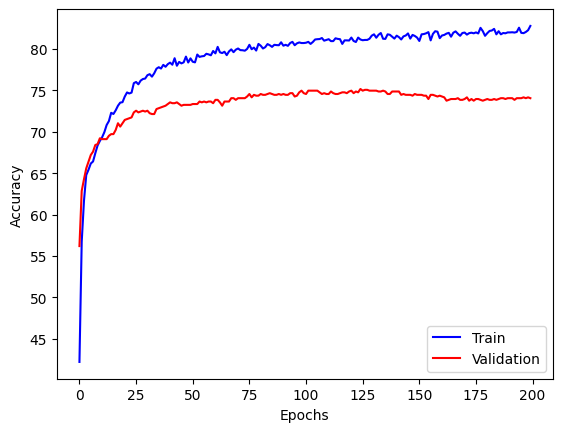


Final model performance t=1
total=991 correct=734 dense accuracy=74.07%
confusion matrix (vertical axis=true, horizontal=predicted):
tensor([236,  69,   2])
tensor([ 37, 143,  62])
tensor([  4,  83, 355])


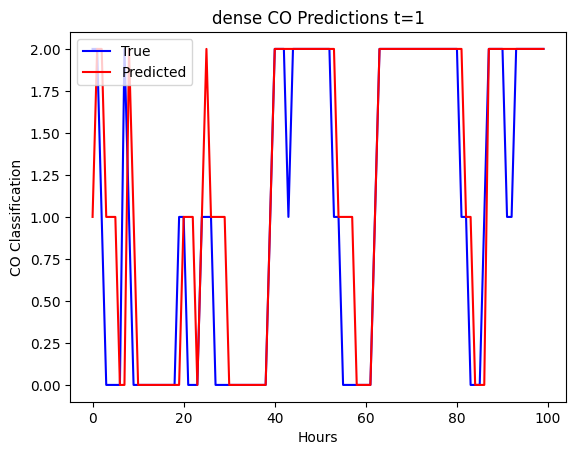

Compared against baseline naive t=1:
(tensor([0, 1, 2]), tensor([307, 243, 442]))

total=991 correct=770 naive accuracy=77.70%
confusion matrix (vertical axis=true, horizontal=predicted):
tensor([256,  49,   2])
tensor([ 40, 138,  64])
tensor([ 10,  56, 376])


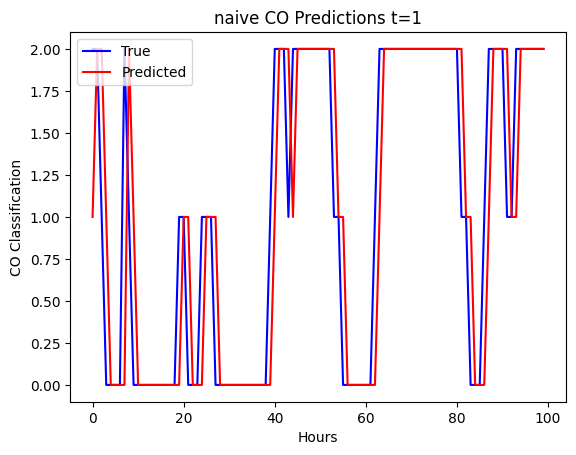

C:\Users\bread\AppData\Local\Temp\ipykernel_22040\1104376364.py:13: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, explain_np, feature_names=list(X_test.columns), plot_type="dot", show=True)


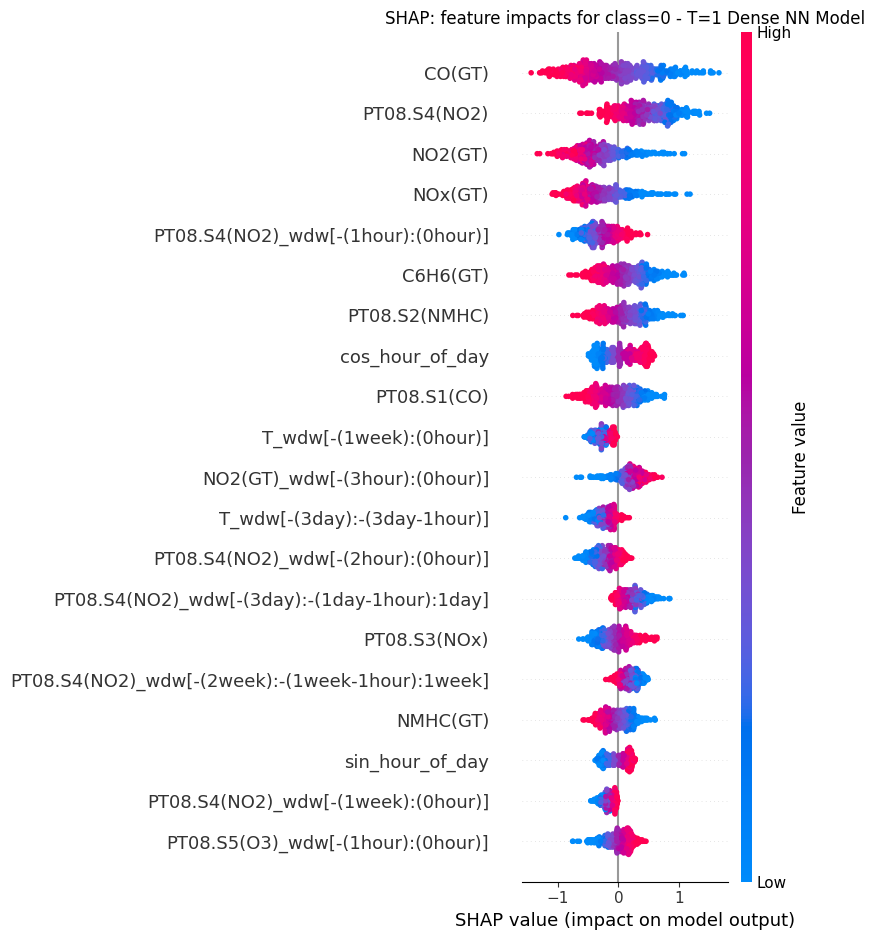

C:\Users\bread\AppData\Local\Temp\ipykernel_22040\1104376364.py:13: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, explain_np, feature_names=list(X_test.columns), plot_type="dot", show=True)


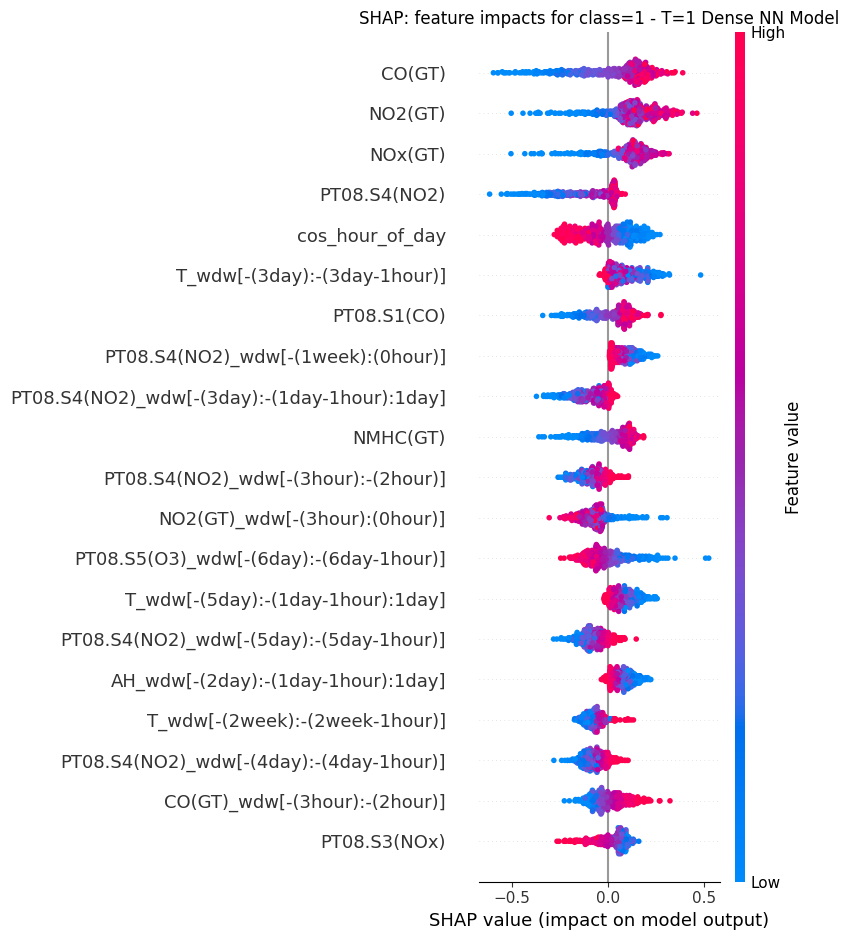

C:\Users\bread\AppData\Local\Temp\ipykernel_22040\1104376364.py:13: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, explain_np, feature_names=list(X_test.columns), plot_type="dot", show=True)


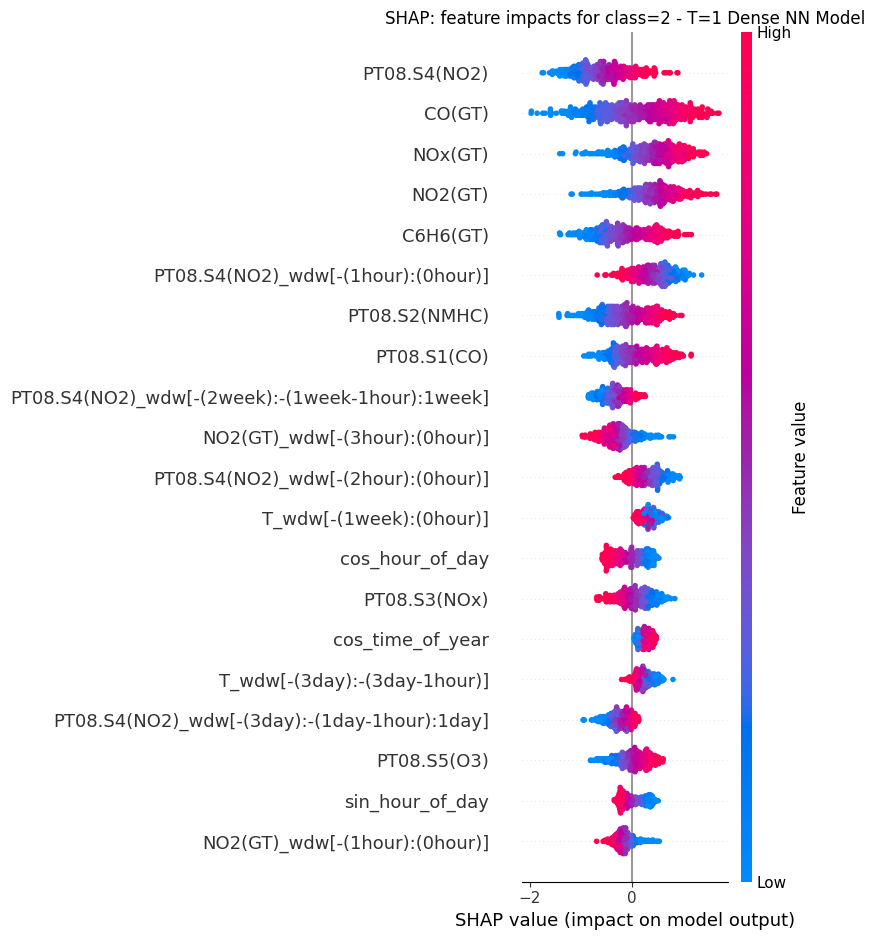

In [24]:
t = 1
epochs = 200
lr = 1e-5

t1_dense_model = Dense().to(device)
t_temporal_prediction(t1_dense_model, t, test_proportion, epochs, batch_size, lr, "dense", evaluate=True)
shap_graph(t1_dense_model, f"T={t} Dense NN Model")

Start training...
total=6600 n_train=5610 n_test=990

ep 1, loss: 191.72, train 40.75%, test 31.31%
ep 2, loss: 189.92, train 42.44%, test 31.92%
ep 3, loss: 187.73, train 42.89%, test 34.04%
ep 4, loss: 186.13, train 44.37%, test 39.90%
ep 5, loss: 184.48, train 45.26%, test 45.86%
ep 6, loss: 182.98, train 47.38%, test 50.81%
ep 7, loss: 180.96, train 48.22%, test 52.42%
ep 8, loss: 180.05, train 49.18%, test 53.03%
ep 9, loss: 178.37, train 50.20%, test 53.43%
ep 10, loss: 176.28, train 51.96%, test 54.04%
ep 11, loss: 174.87, train 53.37%, test 54.85%
ep 12, loss: 172.84, train 55.26%, test 55.25%
ep 13, loss: 171.13, train 56.52%, test 55.66%
ep 14, loss: 169.43, train 56.31%, test 55.76%
ep 15, loss: 167.30, train 56.79%, test 56.26%
ep 16, loss: 165.32, train 59.16%, test 56.36%
ep 17, loss: 163.46, train 59.07%, test 56.67%
ep 18, loss: 161.54, train 60.68%, test 56.57%
ep 19, loss: 160.32, train 59.77%, test 56.46%
ep 20, loss: 157.95, train 61.30%, test 56.26%
ep 21, loss: 15

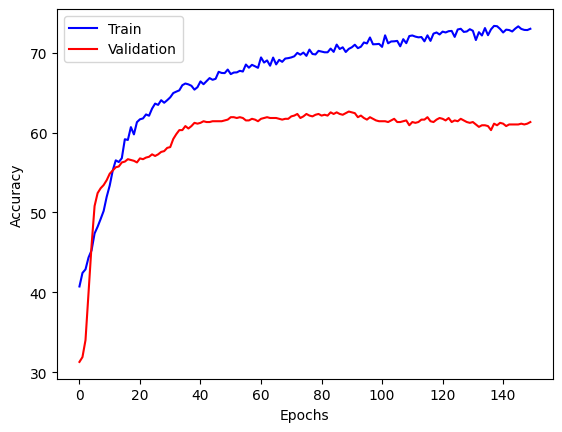


Final model performance t=6
total=990 correct=607 dense accuracy=61.31%
confusion matrix (vertical axis=true, horizontal=predicted):
tensor([231,  25,  51])
tensor([108,  37,  97])
tensor([ 65,  37, 339])


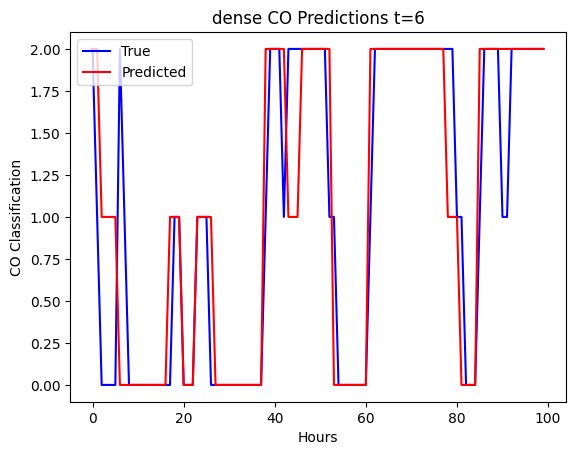

Compared against baseline naive t=6:
(tensor([0, 1, 2]), tensor([307, 247, 442]))

total=990 correct=431 naive accuracy=43.54%
confusion matrix (vertical axis=true, horizontal=predicted):
tensor([133,  99,  75])
tensor([ 71,  51, 120])
tensor([ 97,  97, 247])


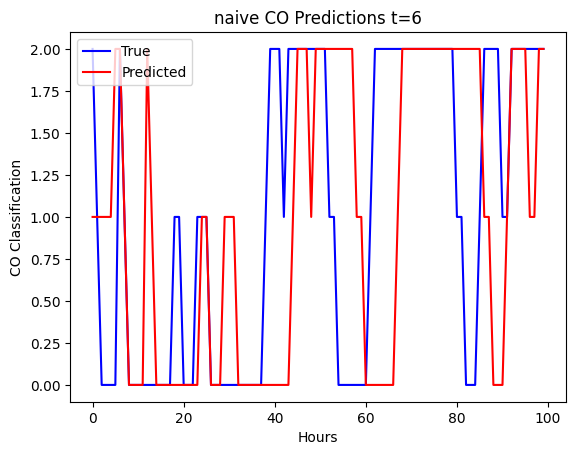

C:\Users\bread\AppData\Local\Temp\ipykernel_22040\1104376364.py:13: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, explain_np, feature_names=list(X_test.columns), plot_type="dot", show=True)


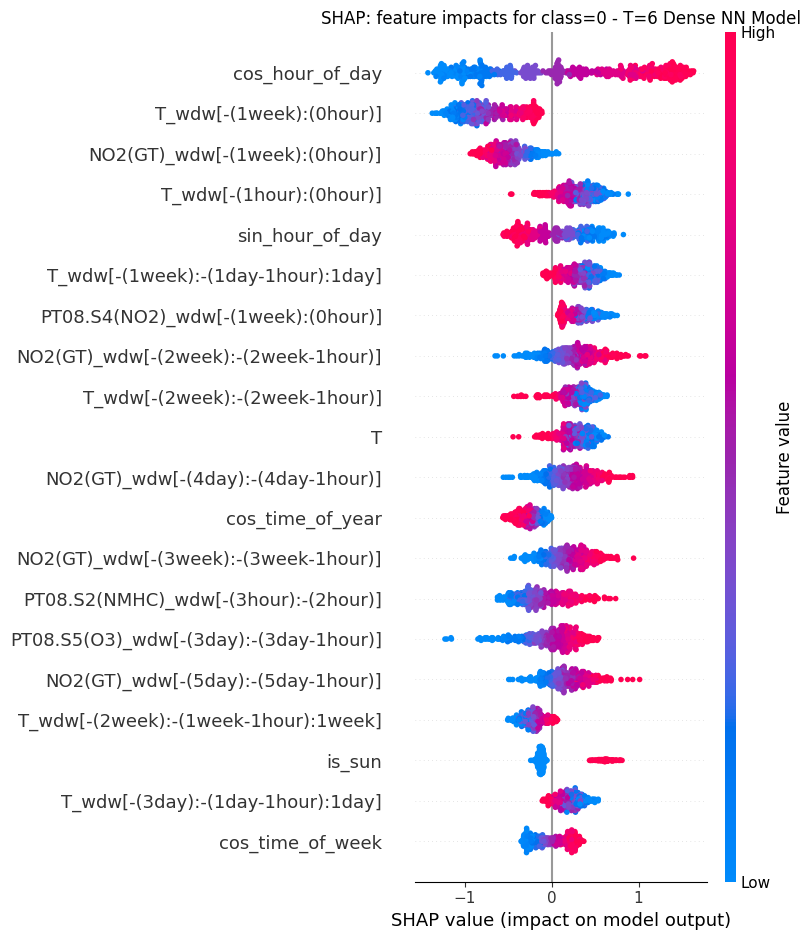

C:\Users\bread\AppData\Local\Temp\ipykernel_22040\1104376364.py:13: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, explain_np, feature_names=list(X_test.columns), plot_type="dot", show=True)


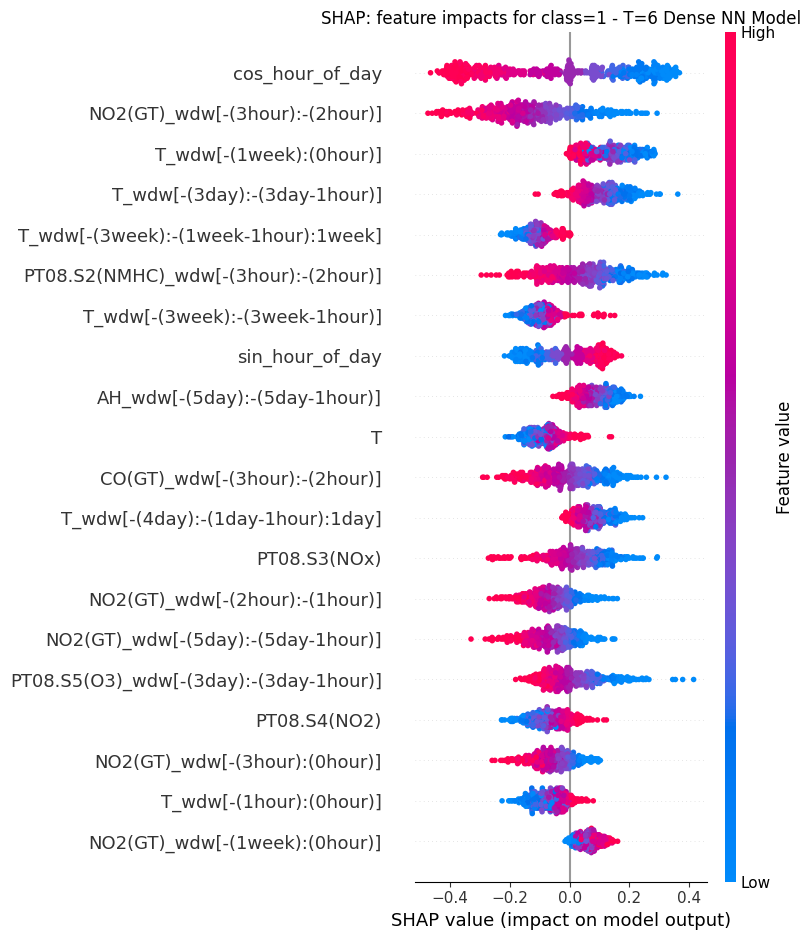

C:\Users\bread\AppData\Local\Temp\ipykernel_22040\1104376364.py:13: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, explain_np, feature_names=list(X_test.columns), plot_type="dot", show=True)


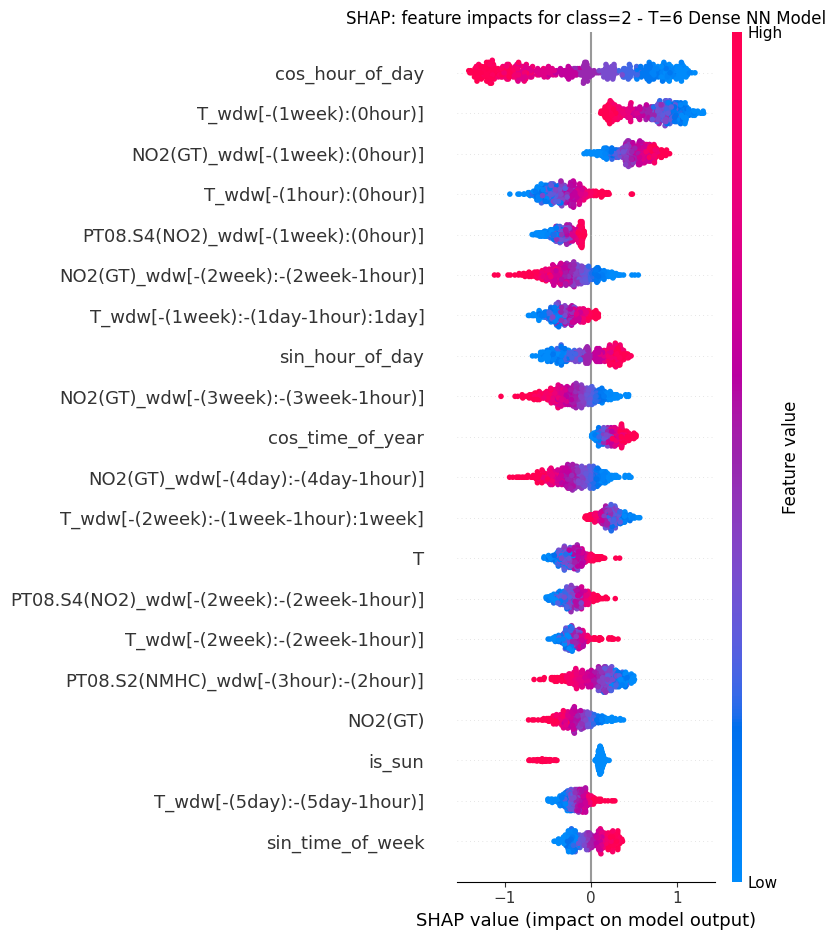

In [21]:
t = 6
epochs = 150
lr = 1e-5

t6_dense_model = Dense().to(device)
t_temporal_prediction(t6_dense_model, t, test_proportion, epochs, batch_size, lr, "dense", evaluate=True)
shap_graph(t6_dense_model, f"T={t} Dense NN Model")

Start training...
total=6594 n_train=5604 n_test=990

ep 1, loss: 192.17, train 35.49%, test 44.55%
ep 2, loss: 187.26, train 44.95%, test 45.15%
ep 3, loss: 183.05, train 49.39%, test 45.25%
ep 4, loss: 179.42, train 50.41%, test 45.66%
ep 5, loss: 175.53, train 51.86%, test 45.96%
ep 6, loss: 172.92, train 52.71%, test 46.06%
ep 7, loss: 170.75, train 53.34%, test 46.06%
ep 8, loss: 168.82, train 53.59%, test 46.77%
ep 9, loss: 166.93, train 54.78%, test 47.27%
ep 10, loss: 164.95, train 55.34%, test 47.68%
ep 11, loss: 163.40, train 55.75%, test 47.88%
ep 12, loss: 162.89, train 56.10%, test 48.38%
ep 13, loss: 161.64, train 57.01%, test 48.89%
ep 14, loss: 159.51, train 56.85%, test 49.80%
ep 15, loss: 158.85, train 57.21%, test 50.00%
ep 16, loss: 158.27, train 57.66%, test 51.72%
ep 17, loss: 156.73, train 57.92%, test 52.22%
ep 18, loss: 155.72, train 59.10%, test 52.73%
ep 19, loss: 154.60, train 59.12%, test 54.04%
ep 20, loss: 153.56, train 58.99%, test 54.85%
ep 21, loss: 15

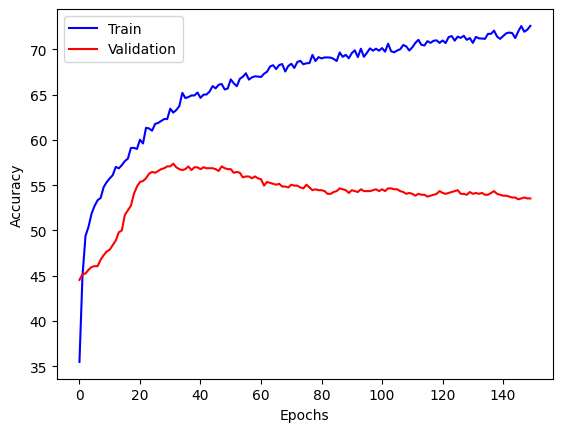


Final model performance t=12
total=990 correct=530 dense accuracy=53.54%
confusion matrix (vertical axis=true, horizontal=predicted):
tensor([179,  38,  90])
tensor([ 79,  37, 126])
tensor([ 58,  69, 314])


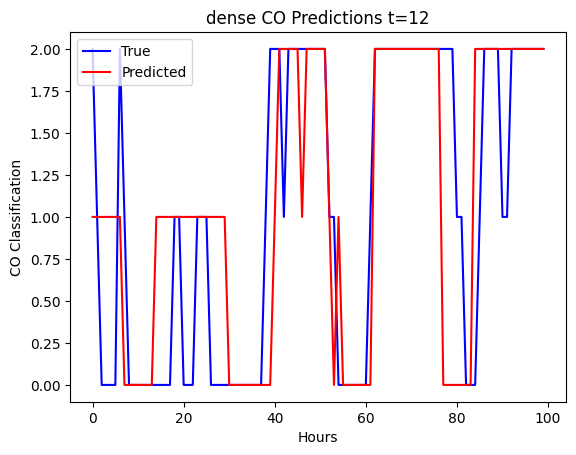

Compared against baseline naive t=12:
(tensor([0, 1, 2]), tensor([309, 249, 444]))

total=990 correct=350 naive accuracy=35.35%
confusion matrix (vertical axis=true, horizontal=predicted):
tensor([ 96,  79, 132])
tensor([ 70,  57, 115])
tensor([131, 113, 197])


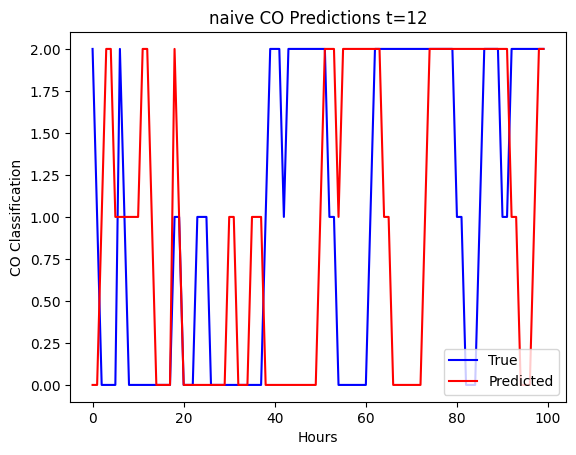

C:\Users\bread\AppData\Local\Temp\ipykernel_22040\1104376364.py:13: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, explain_np, feature_names=list(X_test.columns), plot_type="dot", show=True)


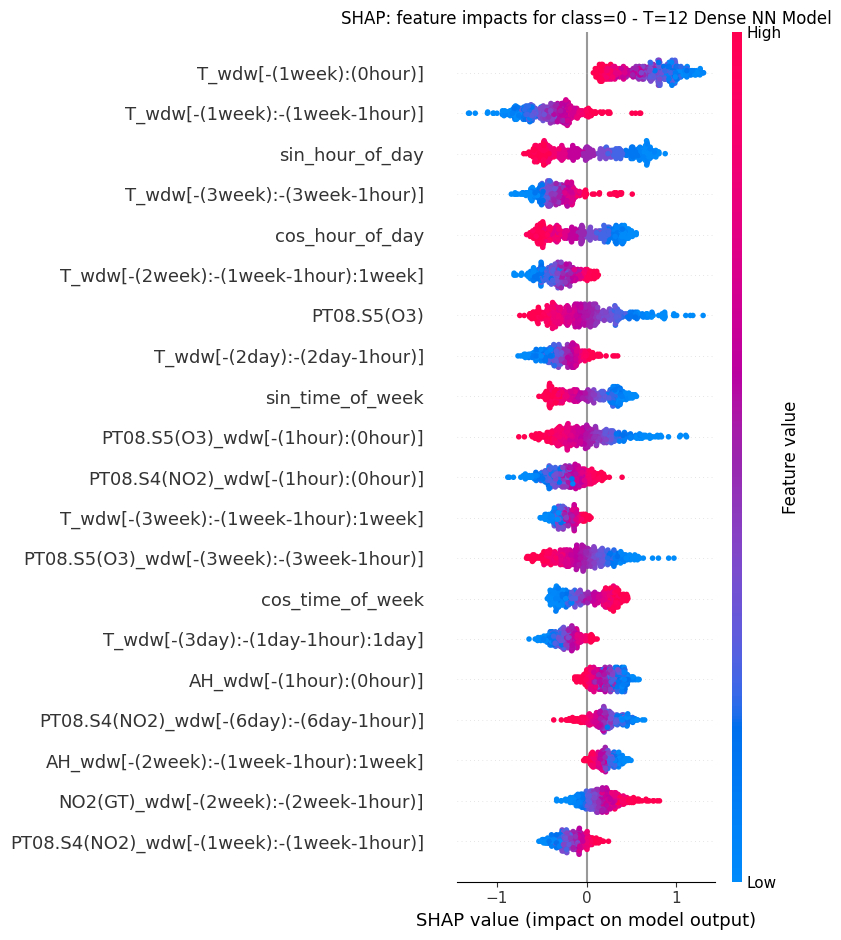

C:\Users\bread\AppData\Local\Temp\ipykernel_22040\1104376364.py:13: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, explain_np, feature_names=list(X_test.columns), plot_type="dot", show=True)


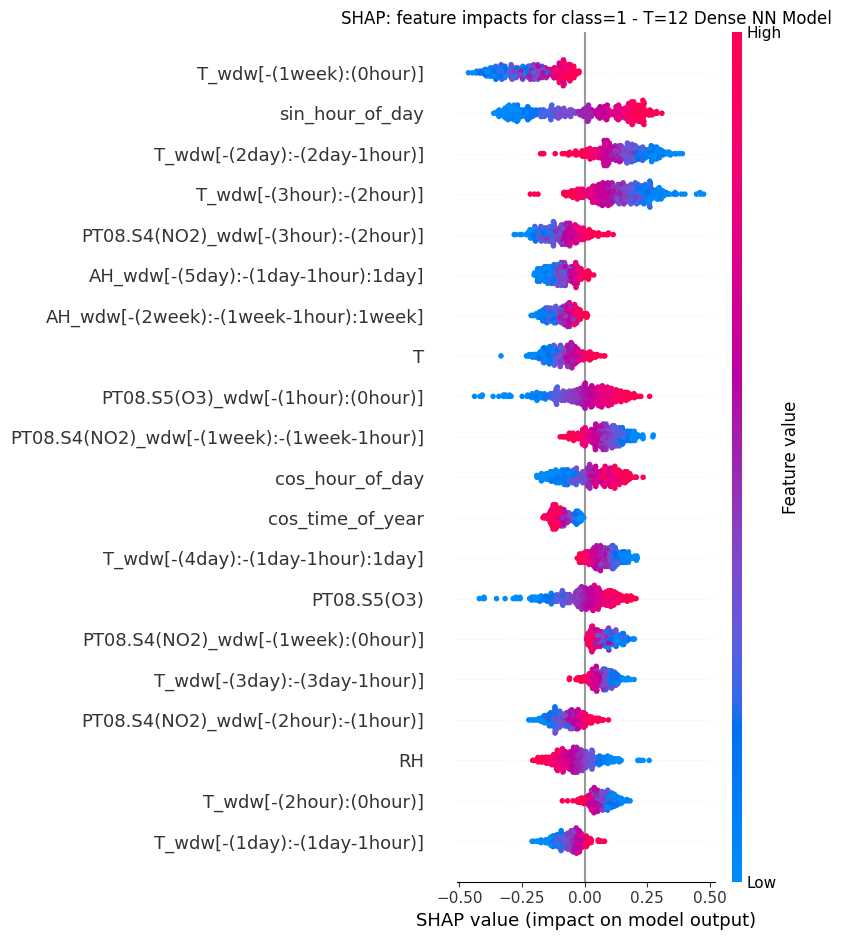

C:\Users\bread\AppData\Local\Temp\ipykernel_22040\1104376364.py:13: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, explain_np, feature_names=list(X_test.columns), plot_type="dot", show=True)


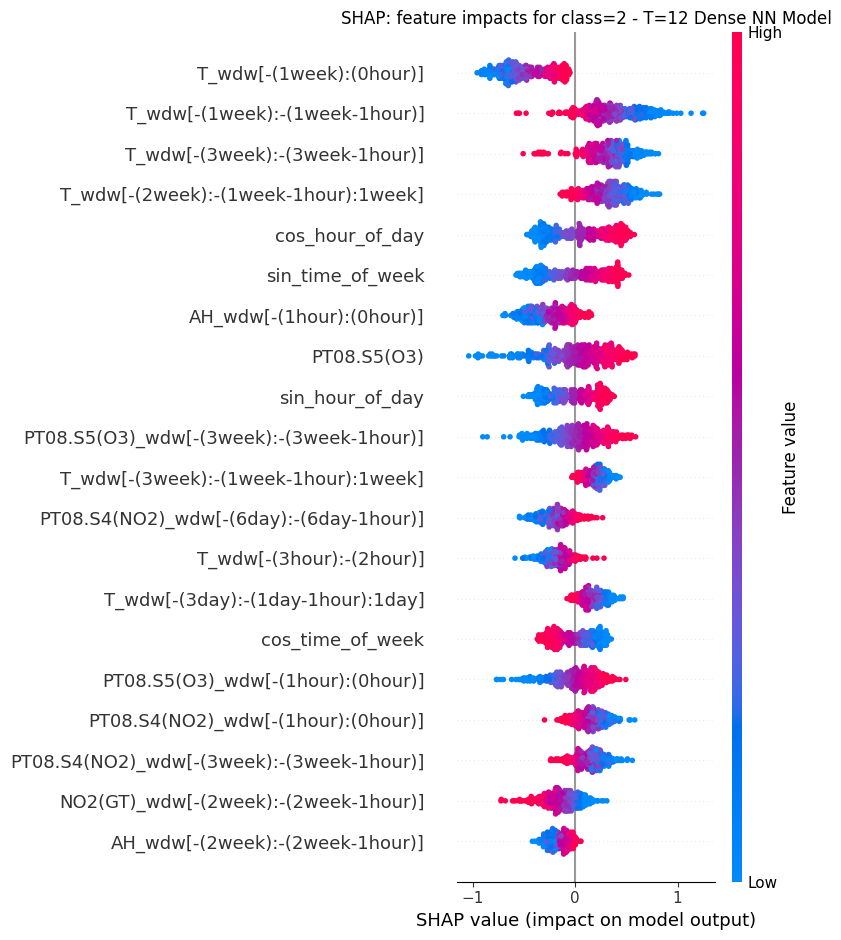

In [22]:
t = 12
epochs = 150
lr = 1e-5

t12_dense_model = Dense().to(device)
t_temporal_prediction(t12_dense_model, t, test_proportion, epochs, batch_size, lr, "dense", evaluate=True)
shap_graph(t12_dense_model, f"T={t} Dense NN Model")

Start training...
total=6582 n_train=5594 n_test=988

ep 1, loss: 191.96, train 35.81%, test 45.45%
ep 2, loss: 181.44, train 54.18%, test 56.38%
ep 3, loss: 171.63, train 61.53%, test 60.53%
ep 4, loss: 163.05, train 62.12%, test 60.43%
ep 5, loss: 155.14, train 63.43%, test 60.12%
ep 6, loss: 148.39, train 63.41%, test 60.43%
ep 7, loss: 143.60, train 63.82%, test 60.22%
ep 8, loss: 139.74, train 64.16%, test 60.53%
ep 9, loss: 136.71, train 64.52%, test 60.43%
ep 10, loss: 134.49, train 65.28%, test 60.53%
ep 11, loss: 132.82, train 65.19%, test 60.63%
ep 12, loss: 131.40, train 65.77%, test 60.63%
ep 13, loss: 129.95, train 66.14%, test 60.53%
ep 14, loss: 129.11, train 66.73%, test 60.63%
ep 15, loss: 128.21, train 66.62%, test 61.03%
ep 16, loss: 127.48, train 66.91%, test 60.73%
ep 17, loss: 126.96, train 66.95%, test 60.32%
ep 18, loss: 126.70, train 67.34%, test 60.43%
ep 19, loss: 125.65, train 67.04%, test 60.32%
ep 20, loss: 125.51, train 67.18%, test 60.53%
ep 21, loss: 12

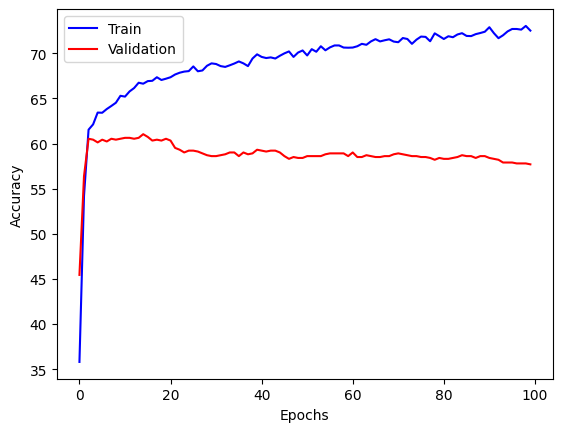


Final model performance t=24
total=988 correct=570 dense accuracy=57.69%
confusion matrix (vertical axis=true, horizontal=predicted):
tensor([190,  42,  75])
tensor([76, 66, 99])
tensor([ 17, 109, 314])


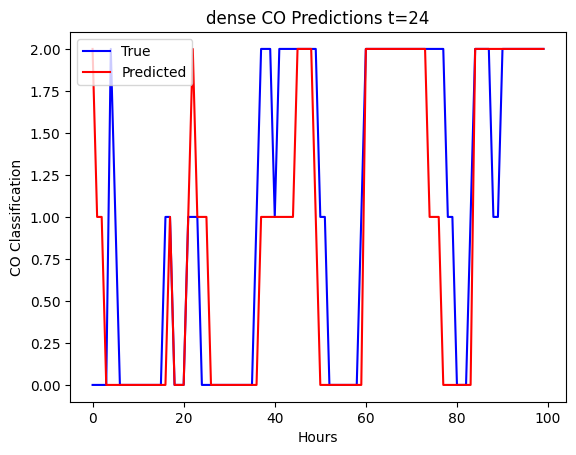

Compared against baseline naive t=24:
(tensor([0, 1, 2]), tensor([311, 250, 451]))

total=988 correct=567 naive accuracy=57.39%
confusion matrix (vertical axis=true, horizontal=predicted):
tensor([185,  64,  58])
tensor([66, 82, 93])
tensor([ 36, 104, 300])


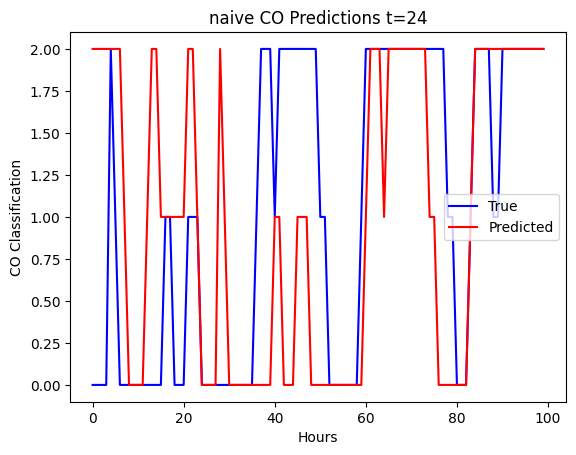

C:\Users\bread\AppData\Local\Temp\ipykernel_22040\1104376364.py:13: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, explain_np, feature_names=list(X_test.columns), plot_type="dot", show=True)


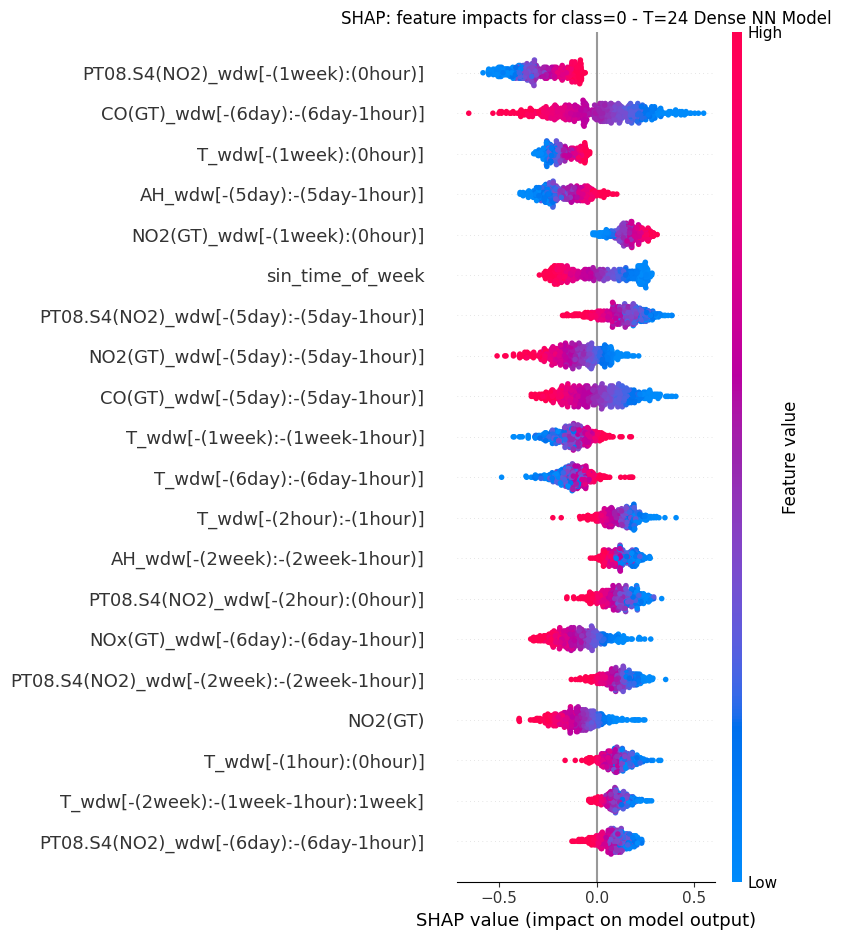

C:\Users\bread\AppData\Local\Temp\ipykernel_22040\1104376364.py:13: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, explain_np, feature_names=list(X_test.columns), plot_type="dot", show=True)


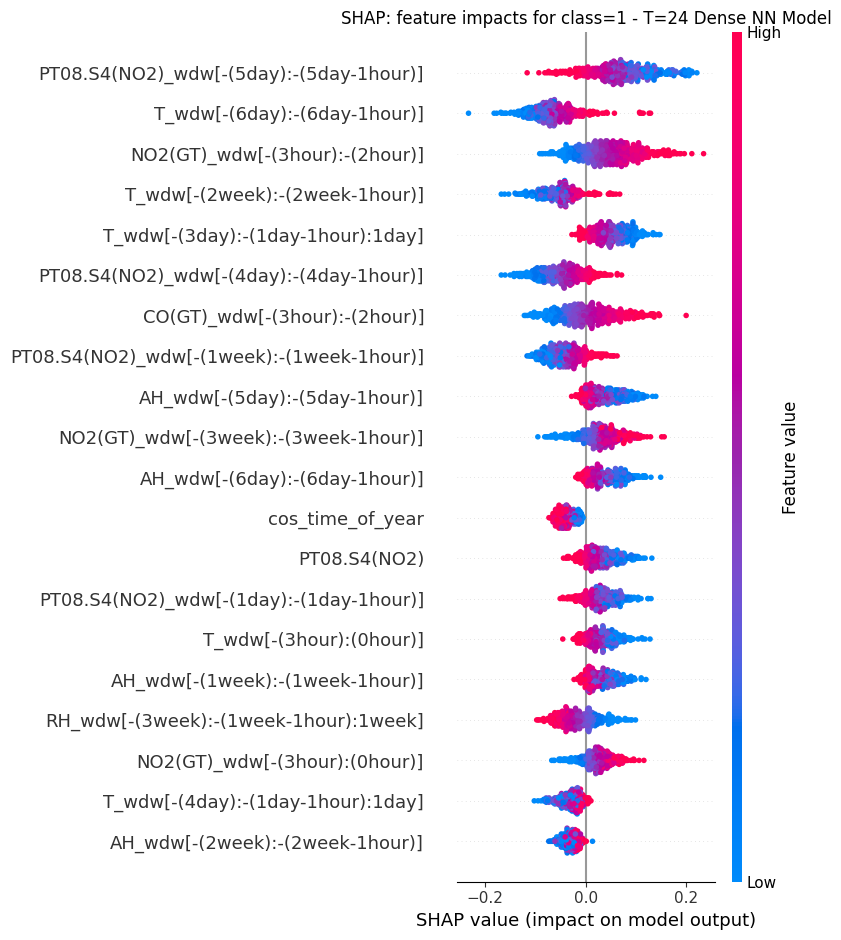

C:\Users\bread\AppData\Local\Temp\ipykernel_22040\1104376364.py:13: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, explain_np, feature_names=list(X_test.columns), plot_type="dot", show=True)


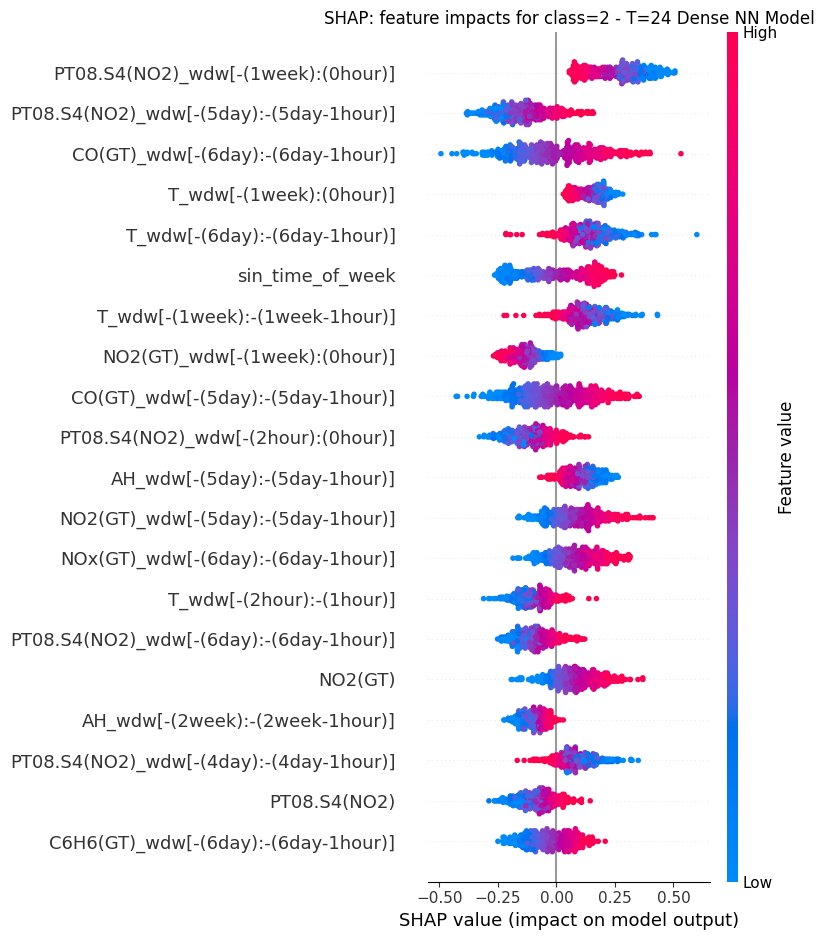

In [23]:
t = 24
epochs = 100
lr = 1e-5
t24_dense_model = Dense().to(device)
t_temporal_prediction(t24_dense_model, t, test_proportion, epochs, batch_size, lr, "dense", evaluate=True)
shap_graph(t24_dense_model, f"T={t} Dense NN Model")